## Building SDG Classifier: Monitor SDGs Development using Machine Learning

#### Group 2
Angel Ren 016729557, Bertha Tam 012313600, Johnny Qiu 016237780, Manyu Zhang 016718858, Yuan Pan 016102138

[Dataset]

The file contains 41,688 text excerpts and a total of 297,625 assigned labels (version 2023.04)

https://zenodo.org/record/7816403#.ZExE-ezML0o
 
[Source Data]

The dataset consists of paragraph-length text excerpts derived from publicly available documents, including reports, policy documents and publication abstracts. A significant number of documents (more than 3,000) originate from UN-related sources such as SDG-Pathfinder and SDG Library. These sources often contain documents that already have SDG labels associated with them. Each text is comprised of 3 to 6 sentences and is about 90 words on average.\

[Column Description]

doi - Digital Object Identifier of the original document

text_id - unique text identifier

text - text excerpt from the document

sdg - the SDG the text is validated against

labels_negative - the number of volunteers who rejected the suggested SDG label

labels_positive - the number of volunteers who accepted the suggested SDG label

agreement - agreement score based on the formula:

agreement = |labelspositive − labelsnegative| / (labelspositive + labelsnegative)

![Image of SDGs](https://upload.wikimedia.org/wikipedia/commons/d/df/Sustainable_Development_Goals.png)

In [ ]:
# dataframe packages
import pandas as pd
import numpy as np

# word vectorization packages
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')
import string
from sklearn.feature_extraction.text import TfidfVectorizer

# visualization packages
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# model training packages
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# model saving package
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmazhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/emmazhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Load data

In [ ]:
df = pd.read_csv('https://zenodo.org/record/7816403/files/osdg-community-data-v2023-04-01.csv?download=1', sep='\t')

df.head()

doi                           text_id  \
0  10.6027/9789289342698-7-en  00021941702cd84171ff33962197ca1f   
1        10.18356/eca72908-en  00028349a7f9b2485ff344ae44ccfd6b   
2  10.1787/9789264289062-4-en  0004eb64f96e1620cd852603d9cbe4d4   
3         10.1787/3726edff-en  0005d3e8b213d9e2cb967666e1aca2e9   
4     10.1787/5k9b7bn5qzvd-en  0006a887475ccfa5a7f5f51d4ac83d02   

                                                text  sdg  labels_negative  \
0  From a gender perspective, Paulgaard points ou...    5                1   
1  Labour legislation regulates maximum working h...   11                2   
2  The average figure also masks large difference...    3                1   
3  Applied research is directed “primarily toward...    9                3   
4  The extent to which they are akin to corruptio...    3                1   

   labels_positive  agreement  
0                8   0.777778  
1                1   0.333333  
2                8   0.777778  
3                6   0.333333  
4                2   0.333333

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41689 entries, 0 to 41688
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   doi              41689 non-null  object 
 1   text_id          41689 non-null  object 
 2   text             41689 non-null  object 
 3   sdg              41689 non-null  int64  
 4   labels_negative  41689 non-null  int64  
 5   labels_positive  41689 non-null  int64  
 6   agreement        41689 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 2.2+ MB


## 2. Data Pre-processing

### Remove Unwanted Columns

In [ ]:
df = df.drop(['doi', 'text_id', 'labels_negative', 'labels_positive'], axis = 1)
df

text  sdg  agreement
0      From a gender perspective, Paulgaard points ou...    5   0.777778
1      Labour legislation regulates maximum working h...   11   0.333333
2      The average figure also masks large difference...    3   0.777778
3      Applied research is directed “primarily toward...    9   0.333333
4      The extent to which they are akin to corruptio...    3   0.333333
...                                                  ...  ...        ...
41684  Since the full capacity is not likely to be ut...    7   0.111111
41685  This article notes the judgment in Sophocleous...   16   0.333333
41686  Groundwater quality can also be affected by co...    6   1.000000
41687  Remedier a ces lacunes est la recommandation p...    2   0.111111
41688  The three diseases that resulted in the greate...    3   0.750000

[41689 rows x 3 columns]

### Handle Missing Values

In [ ]:
# actually there is no missing values, but for checking purpose, we keep this cell. We can remove this as well.
df["text"].replace(" ", np.nan, inplace=True)
df["text"].replace("", np.nan, inplace=True)
df = df.dropna(subset=["text"])
df

text  sdg  agreement
0      From a gender perspective, Paulgaard points ou...    5   0.777778
1      Labour legislation regulates maximum working h...   11   0.333333
2      The average figure also masks large difference...    3   0.777778
3      Applied research is directed “primarily toward...    9   0.333333
4      The extent to which they are akin to corruptio...    3   0.333333
...                                                  ...  ...        ...
41684  Since the full capacity is not likely to be ut...    7   0.111111
41685  This article notes the judgment in Sophocleous...   16   0.333333
41686  Groundwater quality can also be affected by co...    6   1.000000
41687  Remedier a ces lacunes est la recommandation p...    2   0.111111
41688  The three diseases that resulted in the greate...    3   0.750000

[41689 rows x 3 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41689 entries, 0 to 41688
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       41689 non-null  object 
 1   sdg        41689 non-null  int64  
 2   agreement  41689 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 977.2+ KB


### Remove Stopwords and Punctuations

In [ ]:
# define a function to remove punctuations and stopwords
def text_process(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)

In [ ]:
df['text'] = df['text'].apply(text_process)

## 3. Exploratory Data Analysis

### Label Distribution

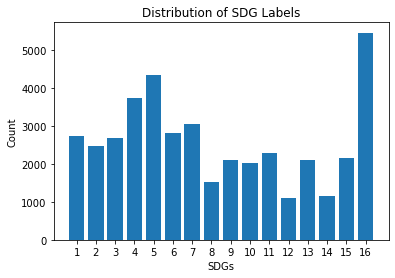

In [ ]:
sdg_counts = df['sdg'].value_counts()
plt.bar(sdg_counts.index, sdg_counts.values)

plt.xticks(sdg_counts.index)
plt.xlabel('SDGs')
plt.ylabel('Count')
plt.title('Distribution of SDG Labels')

plt.show()

### Word Clouds

In [ ]:
sdg_1, sdg_2, sdg_3, sdg_4, sdg_5, sdg_6, sdg_7, sdg_8, sdg_9, sdg_10, sdg_11, sdg_12, sdg_13, sdg_14, sdg_15, sdg_16 = '', '','','','','','','','','','','','','','',''

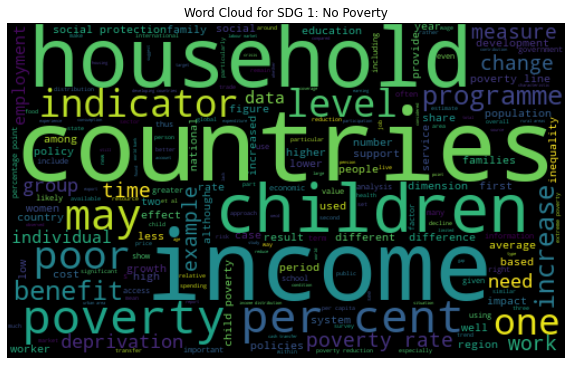

In [ ]:
# Creating a corpus of sdg1
for val in df[df['sdg'] == 1].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_1 = sdg_1 + words + ' '

sdg1_wordcloud = WordCloud(width=500, height=300).generate(sdg_1)

if sdg_1:
    sdg1_wordcloud = WordCloud(width=500, height=300).generate(sdg_1)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(sdg1_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 1: No Poverty")
    plt.show()
else:
    print("No text data associated with SDG 1.")

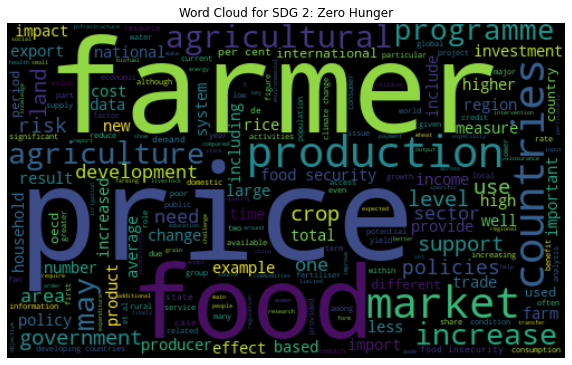

In [ ]:
# Creating a corpus of sdg2
for val in df[df['sdg'] == 2].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_2 = sdg_2 + words + ' '

sdg2_wordcloud = WordCloud(width=500, height=300).generate(sdg_2)

if sdg_2:
    sdg2_wordcloud = WordCloud(width=500, height=300).generate(sdg_2)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(sdg2_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 2: Zero Hunger")
    plt.show()
else:
    print("No text data associated with SDG 2.")

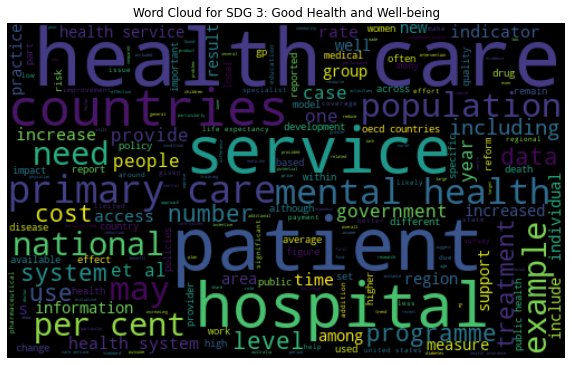

In [ ]:
# Creating a corpus of sdg3
for val in df[df['sdg'] == 3].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_3 = sdg_3 + words + ' '

sdg3_wordcloud = WordCloud(width=500, height=300).generate(sdg_3)

if sdg_3:
    sdg3_wordcloud = WordCloud(width=500, height=300).generate(sdg_3)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(sdg3_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 3: Good Health and Well-being")
    plt.show()
else:
    print("No text data associated with SDG 3.")

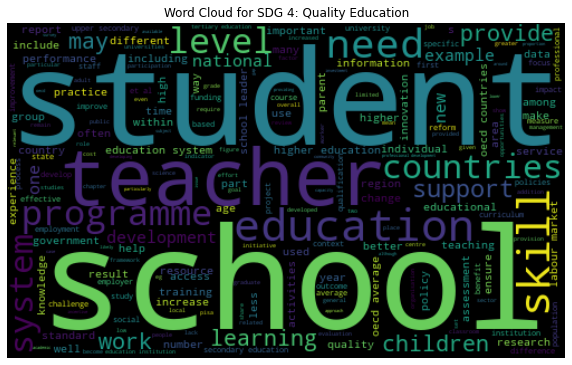

In [ ]:
# Creating a corpus of sdg4
for val in df[df['sdg'] == 4].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_4 = sdg_4 + words + ' '

sdg4_wordcloud = WordCloud(width=500, height=300).generate(sdg_4)

if sdg_4:
    sdg4_wordcloud = WordCloud(width=500, height=300).generate(sdg_4)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(sdg4_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 4: Quality Education")
    plt.show()
else:
    print("No text data associated with SDG 4.")

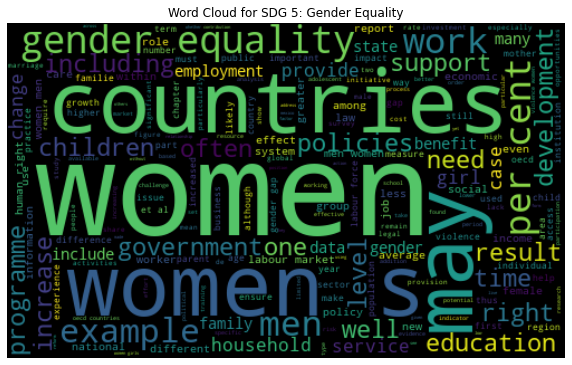

In [ ]:
# Creating a corpus of sdg5
for val in df[df['sdg'] == 5].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_5 = sdg_5 + words + ' '

sdg5_wordcloud = WordCloud(width=500, height=300).generate(sdg_5)

if sdg_5:
    sdg5_wordcloud = WordCloud(width=500, height=300).generate(sdg_5)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(sdg5_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 5: Gender Equality")
    plt.show()
else:
    print("No text data associated with SDG 5.")

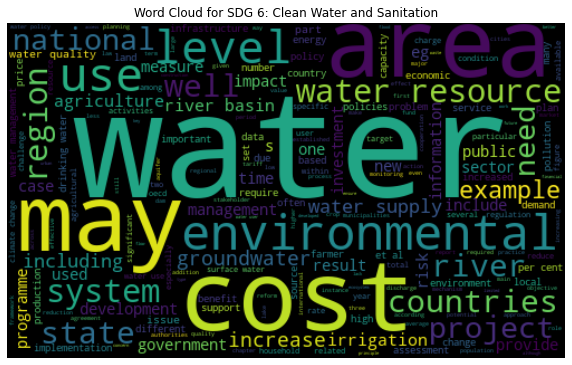

In [ ]:
# Creating a corpus of sdg6
for val in df[df['sdg'] == 6].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_6 = sdg_6 + words + ' '

sdg6_wordcloud = WordCloud(width=500, height=300).generate(sdg_6)

if sdg_6:
    sdg6_wordcloud = WordCloud(width=500, height=300).generate(sdg_6)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(sdg6_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 6: Clean Water and Sanitation")
    plt.show()
else:
    print("No text data associated with SDG 6.")

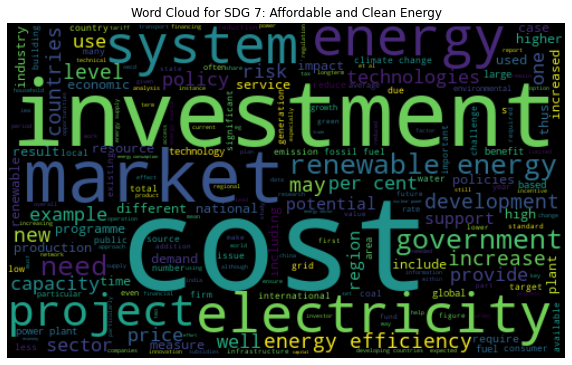

In [ ]:
# Creating a corpus of sdg7
for val in df[df['sdg'] == 7].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_7 = sdg_7 + words + ' '

sdg7_wordcloud = WordCloud(width=500, height=300).generate(sdg_7)

if sdg_7:
    sdg7_wordcloud = WordCloud(width=500, height=300).generate(sdg_7)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(sdg7_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 7: Affordable and Clean Energy")
    plt.show()
else:
    print("No text data associated with SDG 7.")

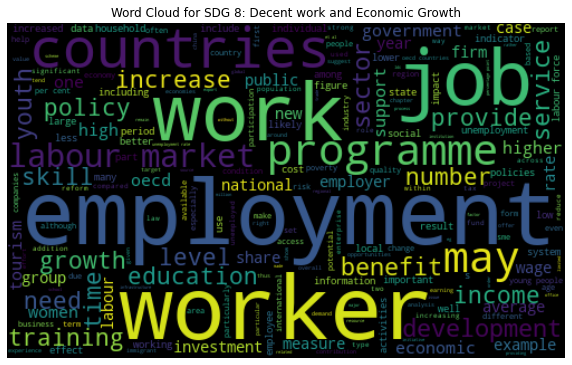

In [ ]:
# Creating a corpus of sdg8
for val in df[df['sdg'] == 8].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_8 = sdg_8 + words + ' '

sdg8_wordcloud = WordCloud(width=500, height=300).generate(sdg_8)

if sdg_8:
    sdg8_wordcloud = WordCloud(width=500, height=300).generate(sdg_8)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(sdg8_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 8: Decent work and Economic Growth")
    plt.show()
else:
    print("No text data associated with SDG 8.")

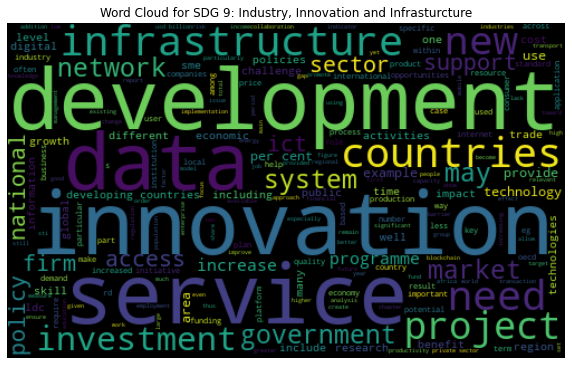

In [ ]:
# Creating a corpus of sdg9
for val in df[df['sdg'] == 9].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_9 = sdg_9 + words + ' '

sdg9_wordcloud = WordCloud(width=500, height=300).generate(sdg_9)

if sdg_9:
    sdg9_wordcloud = WordCloud(width=500, height=300).generate(sdg_9)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(sdg9_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 9: Industry, Innovation and Infrasturcture")
    plt.show()
else:
    print("No text data associated with SDG 9.")

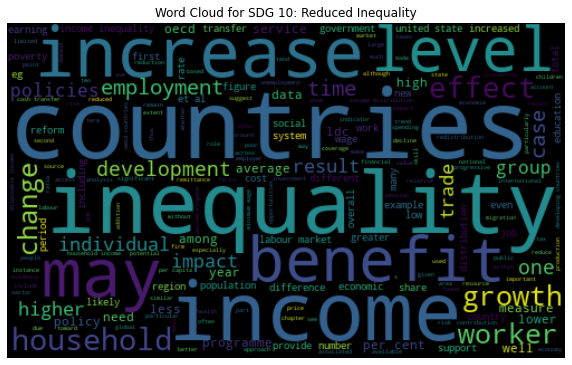

In [ ]:
# Creating a corpus of sdg10
for val in df[df['sdg'] == 10].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_10 = sdg_10 + words + ' '

sdg10_wordcloud = WordCloud(width=500, height=300).generate(sdg_10)

if sdg_10:
    sdg10_wordcloud = WordCloud(width=500, height=300).generate(sdg_10)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(sdg10_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 10: Reduced Inequality")
    plt.show()
else:
    print("No text data associated with SDG 10.")

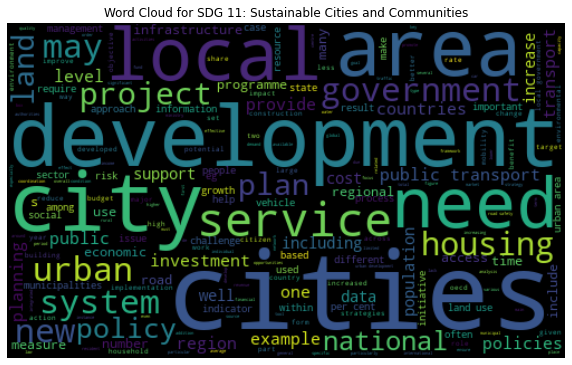

In [ ]:
# Creating a corpus of sdg11
for val in df[df['sdg'] == 11].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_11 = sdg_11 + words + ' '

sdg11_wordcloud = WordCloud(width=500, height=300).generate(sdg_11)

if sdg_11:
    sdg11_wordcloud = WordCloud(width=500, height=300).generate(sdg_11)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(sdg11_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 11: Sustainable Cities and Communities")
    plt.show()
else:
    print("No text data associated with SDG 11.")

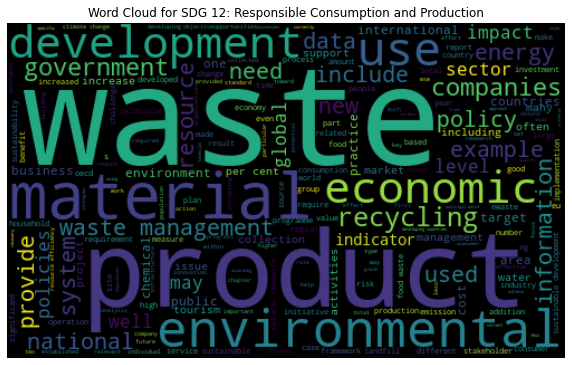

In [ ]:
# Creating a corpus of sdg12
for val in df[df['sdg'] == 12].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_12 = sdg_12 + words + ' '

sdg12_wordcloud = WordCloud(width=500, height=300).generate(sdg_12)

if sdg_12:
    sdg12_wordcloud = WordCloud(width=500, height=300).generate(sdg_12)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(sdg12_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 12: Responsible Consumption and Production")
    plt.show()
else:
    print("No text data associated with SDG 12.")

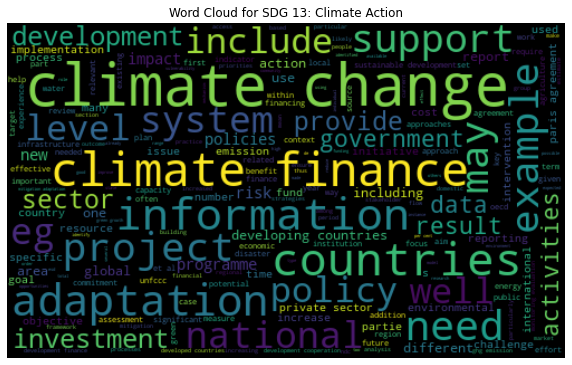

In [ ]:
# Creating a corpus of sdg13
for val in df[df['sdg'] == 13].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_13 = sdg_13 + words + ' '

sdg13_wordcloud = WordCloud(width=500, height=300).generate(sdg_13)

if sdg_13:
    sdg13_wordcloud = WordCloud(width=500, height=300).generate(sdg_13)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(sdg13_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 13: Climate Action")
    plt.show()
else:
    print("No text data associated with SDG 13.")

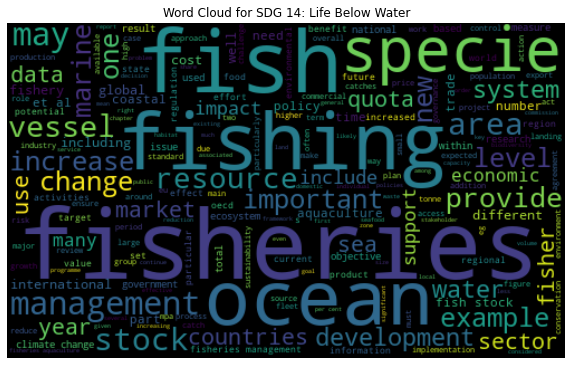

In [ ]:
# Creating a corpus of sdg14
for val in df[df['sdg'] == 14].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_14 = sdg_14 + words + ' '

sdg14_wordcloud = WordCloud(width=500, height=300).generate(sdg_14)

if sdg_14:
    sdg14_wordcloud = WordCloud(width=500, height=300).generate(sdg_14)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(sdg14_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 14: Life Below Water")
    plt.show()
else:
    print("No text data associated with SDG 14.")

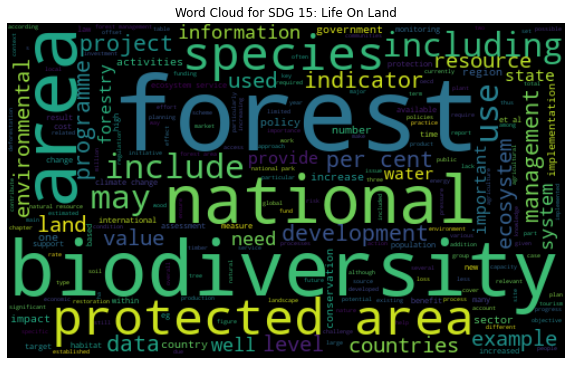

In [ ]:
# Creating a corpus of sdg15
for val in df[df['sdg'] == 15].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_15 = sdg_15 + words + ' '

sdg15_wordcloud = WordCloud(width=500, height=300).generate(sdg_15)

if sdg_15:
    sdg15_wordcloud = WordCloud(width=500, height=300).generate(sdg_15)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(sdg15_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 15: Life On Land")
    plt.show()
else:
    print("No text data associated with SDG 15.")

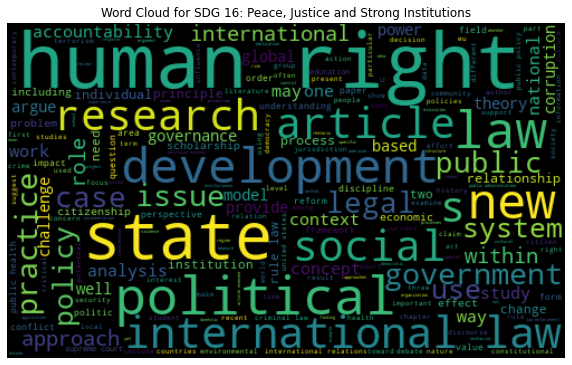

In [ ]:
# Creating a corpus of sdg16
for val in df[df['sdg'] == 16].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        sdg_16 = sdg_16 + words + ' '

sdg16_wordcloud = WordCloud(width=500, height=300).generate(sdg_16)

if sdg_16:
    sdg16_wordcloud = WordCloud(width=500, height=300).generate(sdg_16)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(sdg16_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for SDG 16: Peace, Justice and Strong Institutions")
    plt.show()
else:
    print("No text data associated with SDG 16.")

## 4. Use K-means Clustering to Generate New Labels

### Generate K_labels

In [ ]:
# convert text to vectors with TFIDF Vectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['text'])
vectors.shape

(41689, 79239)

In [ ]:
# Fit K-means model with k=16
kmeans = KMeans(n_clusters = 16, random_state = 42)

# Run K-means with multiple initializations to choose the one with the lowest sum of squared errors (SSE)
best_labels = None
best_inertia = None
for i in range(10):
    kmeans.fit(vectors)
    labels = kmeans.labels_
    inertia = kmeans.inertia_
    if best_inertia is None or inertia < best_inertia:
        best_labels = labels
        best_inertia = inertia

# Print cluster labels of the best solution
print(best_labels)
#print("Best SSE:", best_inertia)

[ 0  0  2 ...  7 14 14]


In [ ]:
# add the new column "k_label" to df
df['k_label'] = best_labels
df

text  sdg  agreement  \
0      gender perspective Paulgaard points labour mar...    5   0.777778   
1      Labour legislation regulates maximum working h...   11   0.333333   
2      average figure also masks large differences ac...    3   0.777778   
3      Applied research directed “primarily towards s...    9   0.333333   
4      extent akin corruption difficult assess 2005 g...    3   0.333333   
...                                                  ...  ...        ...   
41684  Since full capacity likely utilized multiply p...    7   0.111111   
41685  article notes judgment Sophocleous v Secretary...   16   0.333333   
41686  Groundwater quality also affected contaminatio...    6   1.000000   
41687  Remedier ces lacunes est la recommandation pri...    2   0.111111   
41688  three diseases resulted greatest number lost l...    3   0.750000   

       k_label  
0            0  
1            0  
2            2  
3           13  
4           14  
...        ...  
41684       14  
41685        6  
41686        7  
41687       14  
41688       14  

[41689 rows x 4 columns]

In [ ]:
# count the frequency of generated k_labels
df['k_label'].value_counts()

14    13078
13     5223
9      4199
15     2164
6      2075
12     1891
0      1876
2      1599
5      1468
7      1395
1      1393
10     1291
8      1163
11     1147
4       876
3       851
Name: k_label, dtype: int64

### Study the words in k-means clusters

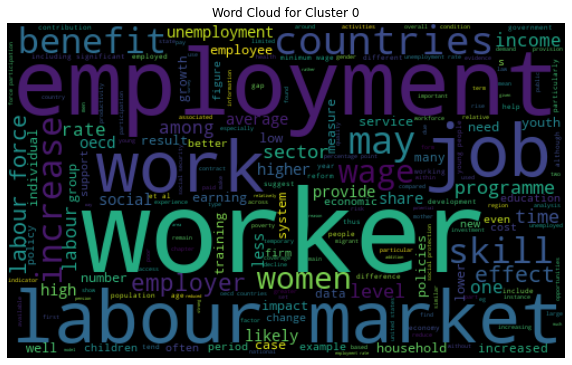

In [ ]:
# Creating a corpus of k_label 0
k = ''

for val in df[df['k_label'] == 0].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 0")
    plt.show()
else:
    print("No text data associated with this cluster.")

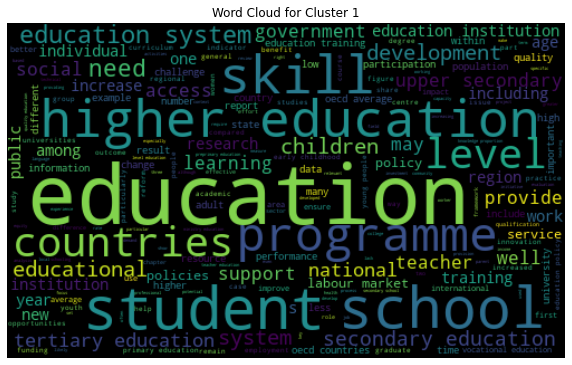

In [ ]:
# Creating a corpus of k_label 1
k = ''

for val in df[df['k_label'] == 1].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 1")
    plt.show()
else:
    print("No text data associated with this cluster.")

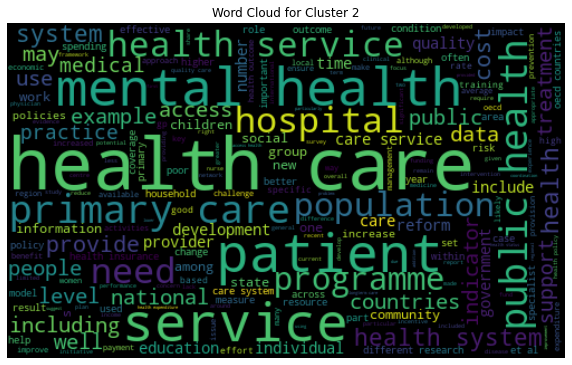

In [ ]:
# Creating a corpus of k_label 2
k = ''

for val in df[df['k_label'] == 2].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 2")
    plt.show()
else:
    print("No text data associated with this cluster.")

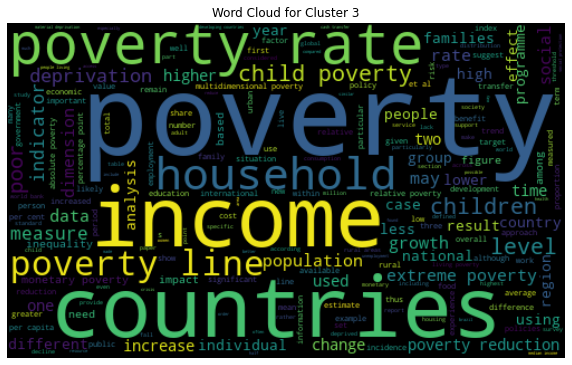

In [ ]:
# Creating a corpus of k_label 3
k = ''

for val in df[df['k_label'] == 3].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 3")
    plt.show()
else:
    print("No text data associated with this cluster.")

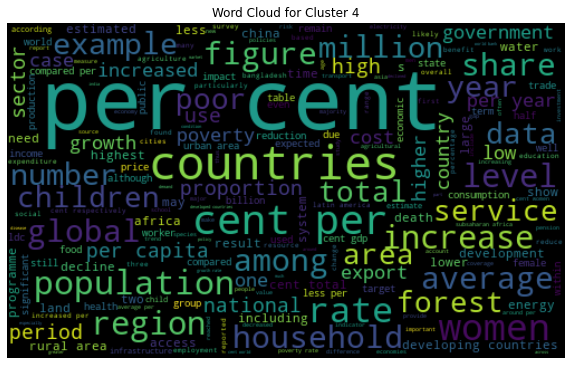

In [ ]:
# Creating a corpus of k_label 4
k = ''

for val in df[df['k_label'] == 4].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 4")
    plt.show()
else:
    print("No text data associated with this cluster.")

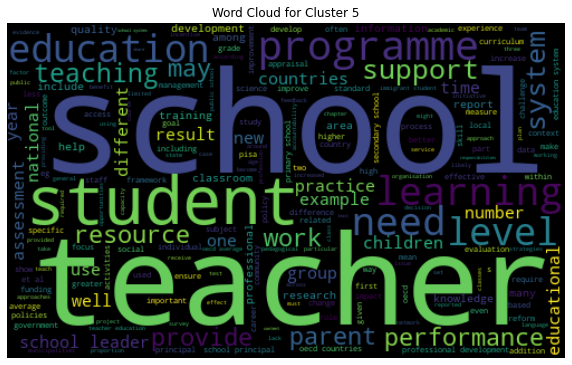

In [ ]:
# Creating a corpus of k_label 5
k = ''

for val in df[df['k_label'] == 5].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 5")
    plt.show()
else:
    print("No text data associated with this cluster.")

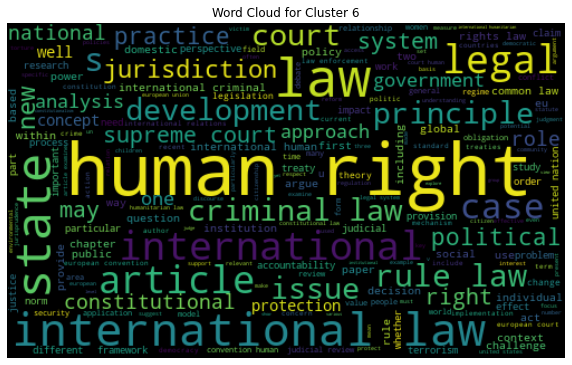

In [ ]:
# Creating a corpus of k_label 6
k = ''

for val in df[df['k_label'] == 6].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 6")
    plt.show()
else:
    print("No text data associated with this cluster.")

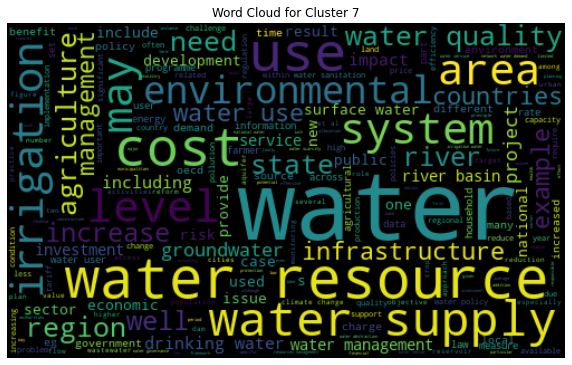

In [ ]:
# Creating a corpus of k_label 7
k = ''

for val in df[df['k_label'] == 7].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 7")
    plt.show()
else:
    print("No text data associated with this cluster.")

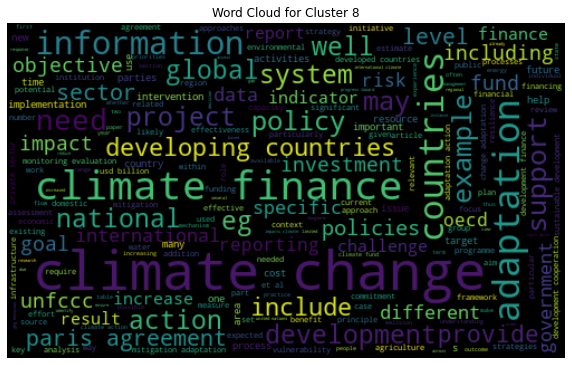

In [ ]:
# Creating a corpus of k_label 8
k = ''

for val in df[df['k_label'] == 8].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 8")
    plt.show()
else:
    print("No text data associated with this cluster.")

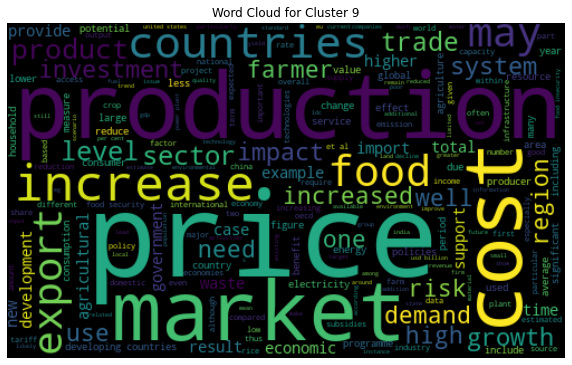

In [ ]:
# Creating a corpus of k_label 9
k = ''

for val in df[df['k_label'] == 9].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 9")
    plt.show()
else:
    print("No text data associated with this cluster.")

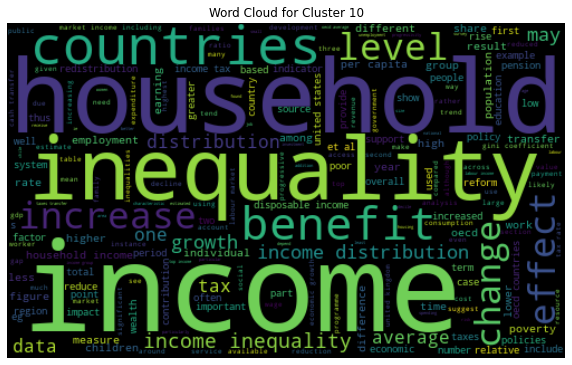

In [ ]:
# Creating a corpus of k_label 10
k = ''

for val in df[df['k_label'] == 10].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 10")
    plt.show()
else:
    print("No text data associated with this cluster.")

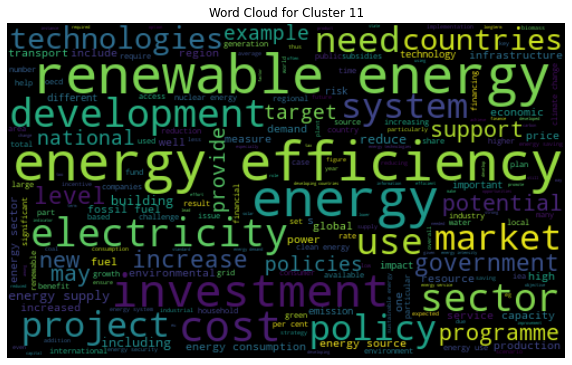

In [ ]:
# Creating a corpus of k_label 11
k = ''

for val in df[df['k_label'] == 11].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 11")
    plt.show()
else:
    print("No text data associated with this cluster.")

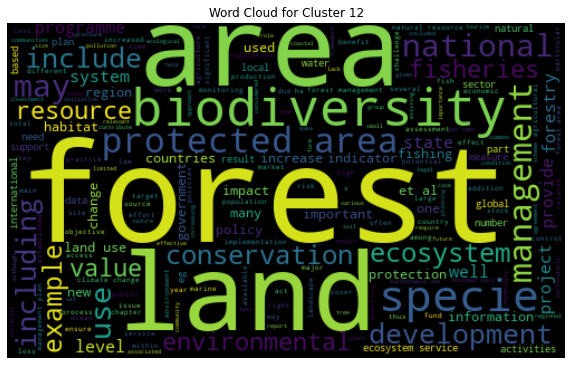

In [ ]:
# Creating a corpus of k_label 12
k = ''

for val in df[df['k_label'] == 12].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 12")
    plt.show()
else:
    print("No text data associated with this cluster.")

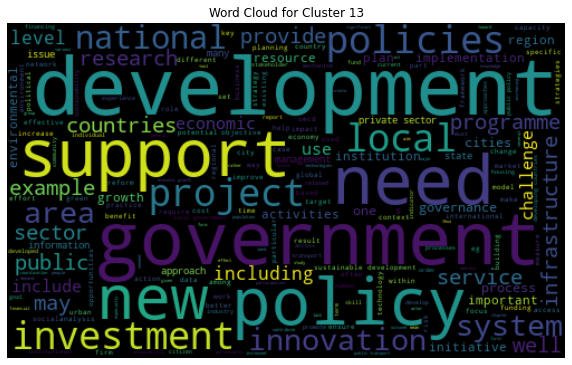

In [ ]:
# Creating a corpus of k_label 13
k = ''

for val in df[df['k_label'] == 13].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 13")
    plt.show()
else:
    print("No text data associated with this cluster.")

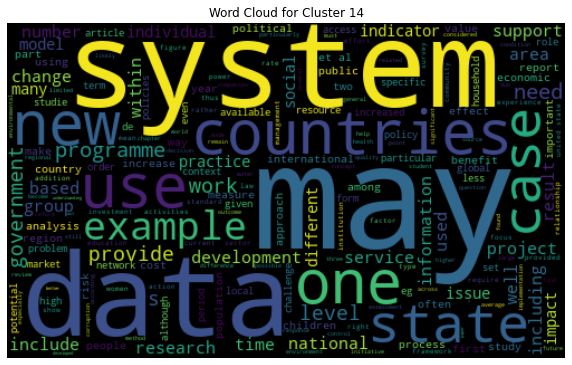

In [ ]:
# Creating a corpus of k_label 14
k = ''

for val in df[df['k_label'] == 14].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 14")
    plt.show()
else:
    print("No text data associated with this cluster.")

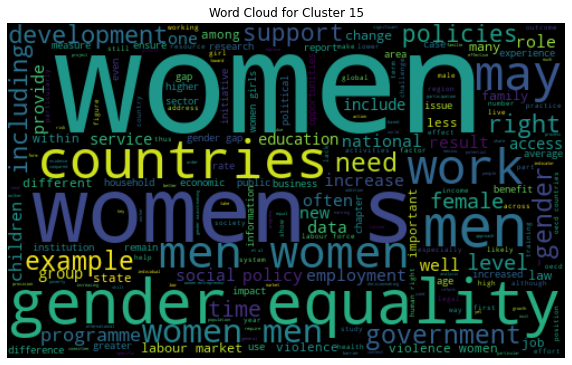

In [ ]:
# Creating a corpus of k_label 15
k = ''

for val in df[df['k_label'] == 15].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        k = k + words + ' '

k_wordcloud = WordCloud(width=500, height=300).generate(k)

if k:
    k_wordcloud = WordCloud(width=500, height=300).generate(k)
    plt.figure(figsize=(10,8), facecolor='w')
    plt.imshow(k_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Cluster 15")
    plt.show()
else:
    print("No text data associated with this cluster.")

### Mannually assign SDG labels to K clusters

After analyzing the word cloud of the newly generated clusters, we discovered that some smaller SDGs were merged into larger, dominant ones, while others with related keywords were merged.

For instance, SDG6 "Clean Water and Sanitation" and SDG14 "Life Below Water" were merged.

Similarly, both Cluster1 and Cluster5 pertain to "Education".

We assigned SDG labels to the clusters as follows, with SDG14 omitted due to no clusters being directly related to it, and SDG17 missing because the original dataset lacks labels for this class.

In [ ]:
# replace multiple values in the 'k_label' column
df['k_label'].replace({0: 8, 
                       1: 4,
                       2: 3,
                       3: 1,
                       4: 12,
                       5: 4,
                       6: 16,
                       7: 6,
                       8: 13,
                       9: 2,
                       10: 10,
                       11: 7,
                       12: 15,
                       13: 11,
                       14: 9,
                       15: 5}, inplace = True)
df

text  sdg  agreement  \
0      gender perspective Paulgaard points labour mar...    5   0.777778   
1      Labour legislation regulates maximum working h...   11   0.333333   
2      average figure also masks large differences ac...    3   0.777778   
3      Applied research directed “primarily towards s...    9   0.333333   
4      extent akin corruption difficult assess 2005 g...    3   0.333333   
...                                                  ...  ...        ...   
41684  Since full capacity likely utilized multiply p...    7   0.111111   
41685  article notes judgment Sophocleous v Secretary...   16   0.333333   
41686  Groundwater quality also affected contaminatio...    6   1.000000   
41687  Remedier ces lacunes est la recommandation pri...    2   0.111111   
41688  three diseases resulted greatest number lost l...    3   0.750000   

       k_label  
0            8  
1            8  
2            3  
3           11  
4            9  
...        ...  
41684        9  
41685       16  
41686        6  
41687        9  
41688        9  

[41689 rows x 4 columns]

In [ ]:
# calculate similarity beween columns k_label and sdg
similarity = (df['k_label'] == df['sdg']).sum() / len(df)
print(f'The similarity between k_label and sdg columns: {similarity:.2%}')

The similarity between k_label and sdg columns: 38.84%


We can tell that the bottom up clusters were significantly different from the original labels, with only 38.84% similarity.

## 5. Model Training with k_labels and original labels respectively

### 5.1 With Original Label

In [ ]:
# select confident instances (based on agreement score) to train the model
data = df[df['agreement'] >= 0.6]

# vecterize text
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
vectors.shape

(24374, 56577)

In [ ]:
#features = word_vectors
X = vectors
y = data['sdg']

# split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# train classifiers
svc = SVC(kernel = 'sigmoid', gamma = 1.0)
knc = KNeighborsClassifier(n_neighbors = 50)
dtc = DecisionTreeClassifier(min_samples_split = 7, random_state = 1)
lrc = LogisticRegression(solver = 'liblinear', penalty = 'l1')
rfc = RandomForestClassifier(n_estimators = 30, random_state = 1)

#create a dictionary of variables and models
clfs = {'SVM' : svc, 'KNN' : knc, 'LR': lrc, 'DT': dtc, 'RF': rfc}

#fit the data onto the models
def train(clf, X, y):    
    clf.fit(X, y)

def predict(clf, X):
    return (clf.predict(X))

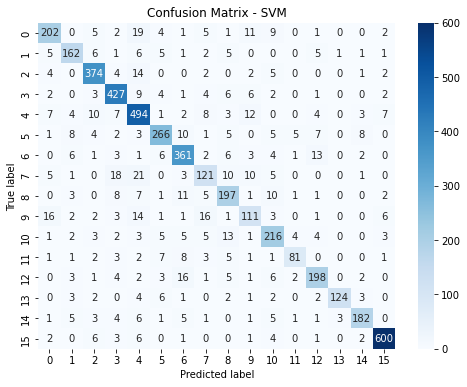

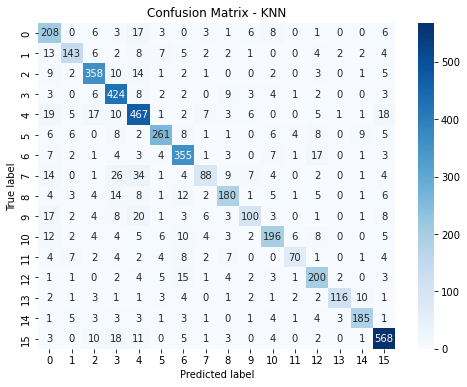

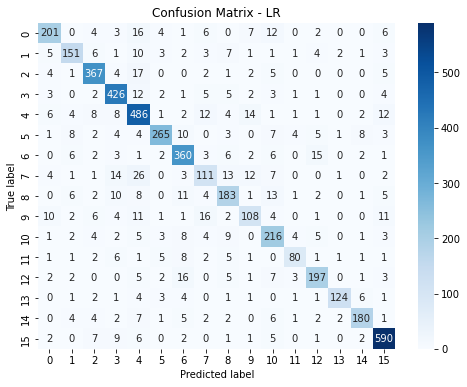

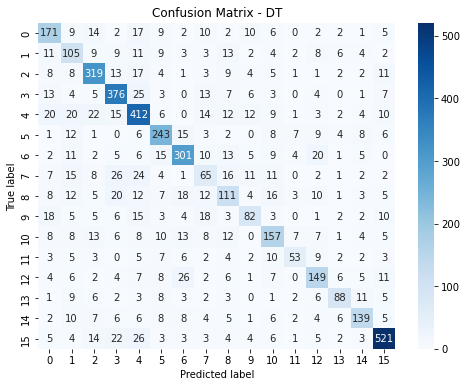

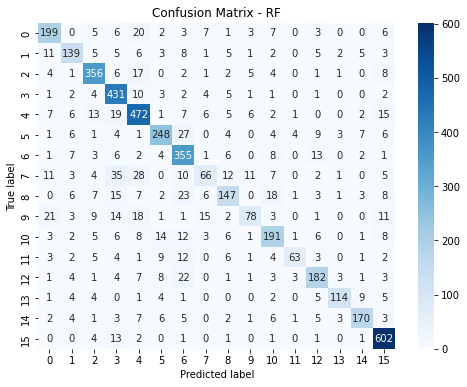

Classifier  Accuracy  F1 Score
0        SVM  0.844308   0.84341
1        KNN  0.803897   0.80086
2         LR  0.829744  0.828339
3         DT  0.675282  0.673207
4         RF  0.782154  0.774727

In [ ]:
# model evaluation
results_df = pd.DataFrame(columns = ['Classifier', 'Accuracy', 'F1 Score'])

for k, v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)

    acc = accuracy_score(y_test , pred)
    f1 = f1_score(y_test, pred, average = 'weighted')
    results_df = results_df.append({'Classifier': k, 'Accuracy': acc, 'F1 Score': f1}, ignore_index = True)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap = 'Blues', fmt='g')
    plt.title(f"Confusion Matrix - {k}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

results_df

### 5.2 With K-means Generated Label

In [ ]:
# use all instances with k_labels to train the model
data = df

# vecterize text
k_vectorizer = TfidfVectorizer()
k_vectors = k_vectorizer.fit_transform(data['text'])
k_vectors.shape

(41689, 79239)

In [ ]:
#features = word_vectors
X = k_vectors
y = data['k_label']

# split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# train classifiers
k_svc = SVC(kernel = 'sigmoid', gamma = 1.0)
k_knc = KNeighborsClassifier(n_neighbors = 50)
k_dtc = DecisionTreeClassifier(min_samples_split = 7, random_state = 1)
k_lrc = LogisticRegression(solver = 'liblinear', penalty = 'l1')
k_rfc = RandomForestClassifier(n_estimators = 30, random_state = 1)

#create a dictionary of variables and models
k_clfs = {'SVM' : k_svc, 'KNN' : k_knc, 'LR': k_lrc, 'DT': k_dtc, 'RF': k_rfc}

#fit the data onto the models
def train(clf, X, y):    
    clf.fit(X, y)

def predict(clf, X):
    return (clf.predict(X))

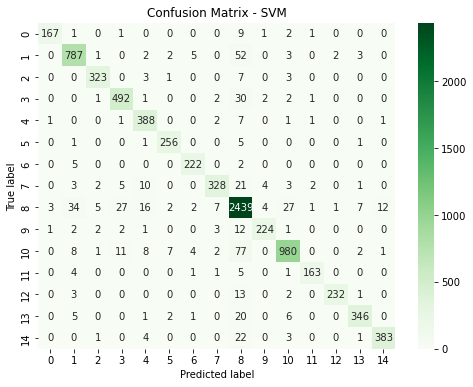

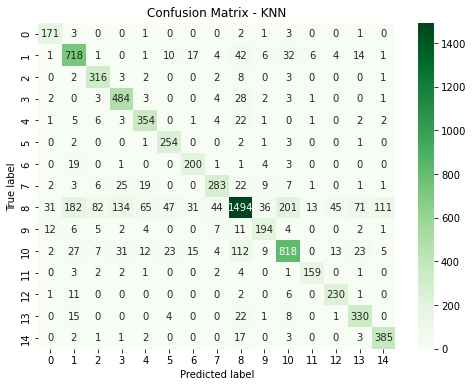

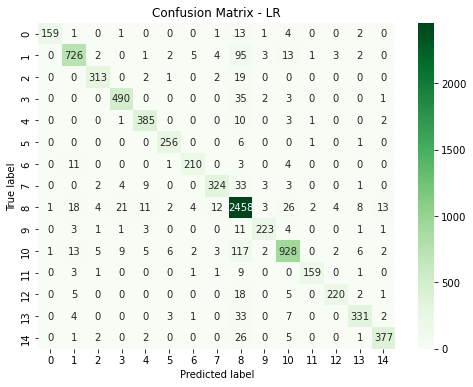

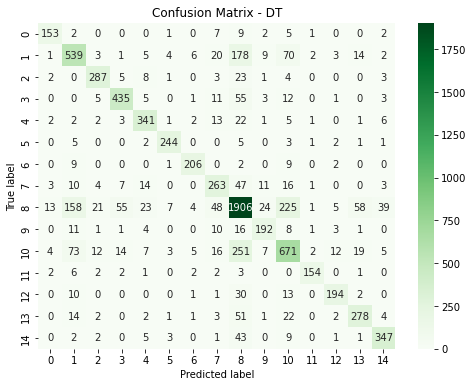

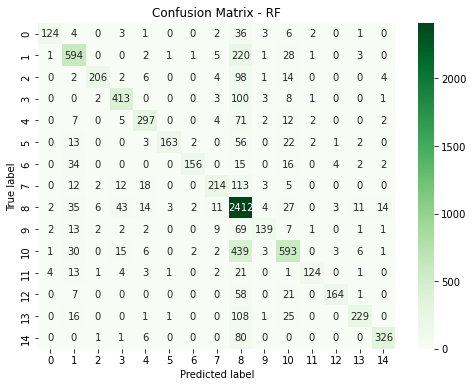

Classifier  Accuracy  F1 Score
0        SVM  0.927081  0.927115
1        KNN  0.766371  0.760153
2         LR  0.906572  0.906502
3         DT  0.744783  0.744724
4         RF  0.738067  0.735977

In [ ]:
# model evaluation
k_results_df = pd.DataFrame(columns = ['Classifier', 'Accuracy', 'F1 Score'])

for k, v in k_clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)

    acc = accuracy_score(y_test , pred)
    f1 = f1_score(y_test, pred, average = 'weighted')
    k_results_df = k_results_df.append({'Classifier': k, 'Accuracy': acc, 'F1 Score': f1}, ignore_index = True)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap = 'Greens', fmt='g')
    plt.title(f"Confusion Matrix - {k}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

k_results_df

All 10 classifiers achieved accuracy and F1 score of over 65%.

Based on both accuracy and F1 score, the SVM classifier outperformed the others, regardless of whether it was trained using the original labels or the k_labels.

## 6. Save Top Models for Demo

In [ ]:
# Save the SVM Model trained by original labels to file in the current working directory

Pkl_Filename1 = "Pickle_SVMO_Model.pkl"  

with open(Pkl_Filename1, 'wb') as file:  
    pickle.dump(svc, file)
    
# Load the Model back from file
with open(Pkl_Filename1, 'rb') as file:  
    Pickled_SVMO_Model = pickle.load(file)

Pickled_SVMO_Model

SVC(gamma=1.0, kernel='sigmoid')

In [ ]:
# Save the SVM Model trained by original labels to file in the current working directory

Pkl_Filename2 = "Pickle_SVMK_Model.pkl"  

with open(Pkl_Filename2, 'wb') as file:  
    pickle.dump(k_svc, file)
    
# Load the Model back from file
with open(Pkl_Filename2, 'rb') as file:  
    Pickled_SVMK_Model = pickle.load(file)

Pickled_SVMK_Model

SVC(gamma=1.0, kernel='sigmoid')

## 7. Demo: Classify New Text
Use SVM classifiers (the top performer) trained by original labels and k_labels to classify new input text.

In [ ]:
sdg_dict = {1: "No Poverty",
            2: "Zero Hunger",
            3: "Good Health and Well-being",
            4: "Quality Education",
            5: "Gender Equality",
            6: "Clean Water and Sanitation",
            7: "Affordable and Clean Energy",
            8: "Decent Work and Economic Growth",
            9: "Industry, Innovation and Infrastructure",
            10: "Reduced Inequality",
            11: "Sustainable Cities and Communities",
            12: "Responsible Consumption and Production",
            13: "Climate Action",
            14: "Life Below Water",
            15: "Life On Land",
            16: "Peace, Justice and Strong Institutions",
            17: "Partnerships for the Goals"
           }

In [ ]:
# write function to detect which SDG the text belongs to
def svm_o(text, sdg_dict):
    newtext = [text]
    integers = vectorizer.transform(newtext)
    label_num = Pickled_SVMO_Model.predict(integers)[0]
    label_name = sdg_dict[label_num]
    print(f'SVM classifier trained by original labels: the text belongs to SDG{label_num} ({label_name}).')
    
def svm_k(text, sdg_dict):
    newtext = [text]
    k_integers = k_vectorizer.transform(newtext)
    k_label_num = Pickled_SVMK_Model.predict(k_integers)[0]
    k_label_name = sdg_dict[k_label_num]
    print(f'SVM classifier trained by k-means generated labels: the text belongs to SDG{k_label_num} ({k_label_name}).')

#### Demo 1
The test text is from a paper related to climate change: https://www.sciencedirect.com/science/article/abs/pii/S0959378010000968?casa_token=N4Cc-VishqUAAAAA:FKG_Ui_1fihsCCnzPp3jag_vFt2enmrAIr20n_phcEaIL89qooFEaXqCWfYx68xKRVEzNZZi

In [ ]:
cc_txt = "Human systems will have to adapt to climate change. Understanding of the magnitude of the adaptation challenge at a global scale, however, is incomplete, constrained by a limited understanding of if and how adaptation is taking place. Here we develop and apply a methodology to track and characterize adaptation action; we apply these methods to the peer-reviewed, English-language literature. Our results challenge a number of common assumptions about adaptation while supporting others: (1) Considerable research on adaptation has been conducted yet the majority of studies report on vulnerability assessments and natural systems (or intentions to act), not adaptation actions. (2) Climate change is rarely the sole or primary motivator for adaptation action. (3) Extreme events are important adaptation stimuli across regions. (4) Proactive adaptation is the most commonly reported adaptive response, particularly in developed nations. (5) Adaptation action is more frequently reported in developed nations, with middle income countries underrepresented and low-income regions dominated by reports from a small number of countries. (6) There is limited reporting on adaptations being developed to take advantage of climate change or focusing on women, elderly, or children."
cc_txt

'Human systems will have to adapt to climate change. Understanding of the magnitude of the adaptation challenge at a global scale, however, is incomplete, constrained by a limited understanding of if and how adaptation is taking place. Here we develop and apply a methodology to track and characterize adaptation action; we apply these methods to the peer-reviewed, English-language literature. Our results challenge a number of common assumptions about adaptation while supporting others: (1) Considerable research on adaptation has been conducted yet the majority of studies report on vulnerability assessments and natural systems (or intentions to act), not adaptation actions. (2) Climate change is rarely the sole or primary motivator for adaptation action. (3) Extreme events are important adaptation stimuli across regions. (4) Proactive adaptation is the most commonly reported adaptive response, particularly in developed nations. (5) Adaptation action is more frequently reported in develop

In [ ]:
svm_o(cc_txt, sdg_dict)
svm_k(cc_txt, sdg_dict)

SVM classifier trained by original labels: the text belongs to SDG13 (Climate Action).
SVM classifier trained by k-means generated labels: the text belongs to SDG13 (Climate Action).


#### Demo 2
The test text is from a paper related to measurement of poverty: https://doi.org/10.2307/1911028

In [ ]:
ii_txt = "Official statistics in the United States and the United Kingdom show a rise in poverty between the 1970's and the 1980's but scepticism has been expressed with regard to these findings. In particular, the methods employed in the measurement of poverty have been the subject of criticism. This paper re-examines three basic issues in measuring poverty: the choice of the poverty line, the index of poverty, and the relation between poverty and inequality. One general theme running through the paper is that there is a diversity of judgments which enter the measurement of poverty and that it is necessary to recognize these explicitly in the procedures adopted. There is likely to be disagreement about the choice of poverty line, affecting both its level and its structure. In this situation, we may only be able to make comparisons and not to measure differences, and the comparisons may lead only to a partial rather than a complete ordering. The first section of the paper discusses the stochastic dominance conditions which allow such comparisons, illustrating their application by reference to data for the United States. The choice of poverty measure has been the subject of an extensive literature and a variety of measures have been proposed. In the second section of the paper a different approach is suggested, considering a class of measures satisfying certain general properties and seeking conditions under which all members of the class (which includes many of those proposed) give the same ranking. Those sceptical about measures of poverty often assert that poverty and inequality are being confounded. The third section of the paper distinguishes four different viewpoints and relates them to theories of justice and views of social welfare."
ii_txt

"Official statistics in the United States and the United Kingdom show a rise in poverty between the 1970's and the 1980's but scepticism has been expressed with regard to these findings. In particular, the methods employed in the measurement of poverty have been the subject of criticism. This paper re-examines three basic issues in measuring poverty: the choice of the poverty line, the index of poverty, and the relation between poverty and inequality. One general theme running through the paper is that there is a diversity of judgments which enter the measurement of poverty and that it is necessary to recognize these explicitly in the procedures adopted. There is likely to be disagreement about the choice of poverty line, affecting both its level and its structure. In this situation, we may only be able to make comparisons and not to measure differences, and the comparisons may lead only to a partial rather than a complete ordering. The first section of the paper discusses the stochast

In [ ]:
svm_o(ii_txt, sdg_dict)
svm_k(ii_txt, sdg_dict)

SVM classifier trained by original labels: the text belongs to SDG1 (No Poverty).
SVM classifier trained by k-means generated labels: the text belongs to SDG9 (Industry, Innovation and Infrastructure).


### Summary
Based on the classifiers, whether built with original labels or k-means generated labels, they can provide labels that correspond to the SDGs when new data comes in.

However, for data that may be ambiguous, such as the second example, it may be classified into different SDGs, such as SDG1 (No Poverty) or SDG9 (Industry, Innovation and Infrastructure).

In conclusion, relying solely on supervised classification or unsupervised clustering cannot provide 100% accurate results. Human involvement is significant, and we should consider leveraging human experts to create multi-label datasets so that we can classify ambiguous data more accurately.